Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


Using TensorFlow backend.


Loading data and splitting into Train and Test datasets

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(" ")
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Extracting unique values of labels

In [3]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

plotting a figure of feature

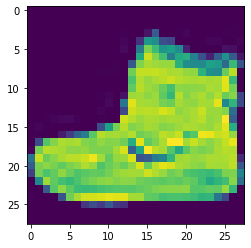

In [4]:
plt.figure(figsize=(6,4))
plt.imshow(X_train[0])
plt.show()

Reshaping of Features for inputs

In [5]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Converting Channel 1 to Channel 3

In [6]:
X_train = np.repeat(X_train,3,-1)
X_test = np.repeat(X_test,3,-1)

X_train.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Normalization of features

In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Converting labels into Binary form

In [8]:
y_train = np_utils.to_categorical(y_train.astype('float32'),num_classes=10)
y_test = np_utils.to_categorical(y_test.astype('float32'),num_classes=10)

y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [9]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])

# Display the new shape
X_train.shape, X_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [10]:
# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [11]:
y_train.shape, y_test.shape

((48000, 10), (10000, 10))

Building model

In [0]:
#model = ResNet50(include_top=True, weights=None, input_shape=(48,48,3), classes=10, classifier_activation='softmax')
#model.summary()

In [14]:
# Create the base model of VGG19
model = VGG16(weights='imagenet', include_top=False, input_shape = (48,48,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [0]:
# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [16]:
# Extracting features
train_features = model.predict(np.array(X_train), batch_size=100, verbose=1)
test_features = model.predict(np.array(X_test), batch_size=100, verbose=1)
val_features = model.predict(np.array(X_val), batch_size=100, verbose=1)

120/120 [==============================] - 8s 69ms/step


In [0]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [18]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [0]:
# Flatten extracted features
train_features = np.reshape(train_features, (48000, 1*1*512))
test_features = np.reshape(test_features, (10000, 1*1*512))
val_features = np.reshape(val_features, (12000, 1*1*512))

In [0]:

from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

# Add Dense layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:

# Incorporating reduced learning and early stopping for callback
from tensorflow.keras import callbacks
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, early_stopping]


In [23]:
# Train the the model
model.fit(train_features, y_train, epochs=50, validation_data=(val_features, y_val), callbacks=callbacks)

Epoch 1/50
1500/1500 [==============================] - 5s 4ms/step - loss: 2.3865 - accuracy: 0.1298 - val_loss: 2.3337 - val_accuracy: 0.1226 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 5s 4ms/step - loss: 2.2534 - accuracy: 0.1587 - val_loss: 2.1830 - val_accuracy: 0.1876 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 5s 4ms/step - loss: 2.1924 - accuracy: 0.1818 - val_loss: 2.1555 - val_accuracy: 0.1900 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 5s 4ms/step - loss: 2.1611 - accuracy: 0.1941 - val_loss: 2.1579 - val_accuracy: 0.2057 - lr: 0.0010
Epoch 5/50
1487/1500 [============================>.] - ETA: 0s - loss: 2.1359 - accuracy: 0.2070
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 5s 4ms/step - loss: 2.1357 - accuracy: 0.2072 - val_loss: 2.1668 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 6/50
1500/1500 [=========================

In [0]:
model.save("/content/drive/My Drive/FMNIST/fashion_mnist_vgg19.h5")